# Hamiltonian Monte Carlo estimates of RLCT

We train a small neural network to "convergence" at a weight vector `w_0` and then initialise Hamiltonian Monte Carlo (HMC) to estimate the posterior in a ball around `w_0` for a range of inverse temperatures. This is done by switching from a global prior to a local prior, which is a Gaussian concentrated at `w_0`. Finally we sample from these probability distributions to generate an estimate of the local Real Log Canonical Threshold (RLCT) of the neural network around `w_0`.

This code is heavily based on notebooks found here:
https://colab.research.google.com/drive/1bWQcuR5gaBPpow6ARKnPPL-dtf2EvTae#scrollTo=zNhVpzE95IGp
https://github.com/tensorflow/probability/issues/292

In [1]:
class Args:
  num_betas = 20
  prior_std_dev = 5e-6 # local prior, default 1e-6
  symmetry_factor = 3 # symmetry of the true distribution
  H = 10 # number of hidden nodes in the model class
  num_posterior_samples = 100 # r in the writeup

  mc_burnin_steps=1000
  mc_leapfrog_steps=5
  mc_adaptation_steps=800
  mc_step_size=1e-8
  mc_num_results=5000
  
args = Args()

# 1. Setup

In [2]:
from __future__ import print_function

import math
from datetime import datetime
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.preprocessing
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from sklearn.linear_model import ElasticNet

tfd = tfp.distributions

tf.enable_v2_behavior()

In [3]:
def dense(X, W, b, activation):
    return activation(tf.matmul(X, W) + b)

def build_network(weights_list, biases_list, activation=tf.nn.relu):
    def model(X):
        net = X
        for (weights, biases) in zip(weights_list[:-1], biases_list[:-1]):
            net = dense(net, weights, biases, activation)
        # final linear layer
        final_w = weights_list[-1]
        final_b = biases_list[-1]
        net = tf.matmul(net, final_w) + final_b
        preds = net[:, 0]
        std_devs = tf.exp(-net[:, 1])
        # preds and std_devs each have size N = X.shape(0) (the number of data samples)
        # and are the model's predictions and (log-sqrt of) learned loss attenuations, resp.
        return tfd.Normal(loc=preds, scale=std_devs)

    return model

def get_initial_state_true_zeros(num_hidden):
    """generate a symmetric true distribution
    Keyword Arguments:
        num_hidden -- number of nodes in the single hidden layer
    Returns:
        list -- architecture of FCNN with weigths and bias tensors for each layer
    """
    # make sure the last layer has two nodes, so that output can be split into
    # predictive mean and learned loss attenuation (see https://arxiv.org/abs/1703.04977)
    # which the network learns individually
    layers = (
        2,
        num_hidden,
        2,
    )
    
    architecture = []
    for idx in range(len(layers) - 1):
        weights = tf.zeros((layers[idx], layers[idx + 1]))
        biases = tf.zeros((layers[idx + 1]))
        architecture.extend((weights, biases))
    return architecture
  
def get_initial_state_true(num_hidden):
    """generate a symmetric true distribution
    Keyword Arguments:
        num_hidden -- number of nodes in the single hidden layer
    Returns:
        list -- architecture of FCNN with weigths and bias tensors for each layer
    """
    # make sure the last layer has two nodes, so that output can be split into
    # predictive mean and learned loss attenuation (see https://arxiv.org/abs/1703.04977)
    # which the network learns individually
    layers = (
        2,
        num_hidden,
        2,
    )

    a = 2 * np.pi / num_hidden
    t1 = np.array([[np.cos(a/2), np.sin(a/2)]])
    
    w = np.vstack([ np.matmul(t1, np.array([[np.cos(k*a), -np.sin(k*a)],
                                             [np.sin(k*a), np.cos(k*a)]])) for k in range(num_hidden)])
    w = np.transpose(w)
    b = -0.3 * np.ones((num_hidden))
    
    # The second output note is logits for the std_dev (= exp(-logit))
    q = np.transpose(np.vstack([np.ones((num_hidden)), np.zeros((num_hidden))]))
    c = np.array([0.0, 0.0])
    
    architecture = []
    architecture.extend((w.astype("float32"),b.astype("float32")))
    architecture.extend((q.astype("float32"),c.astype("float32")))
    
    return architecture
  
def get_initial_state(weight_prior, bias_prior, num_hidden):
    """generate starting point for creating Markov chain
        of weights and biases for fully connected NN
    Keyword Arguments:
        num_hidden -- number of nodes in the single hidden layer
    Returns:
        list -- architecture of FCNN with weigths and bias tensors for each layer
    """
    # make sure the last layer has two nodes, so that output can be split into
    # predictive mean and learned loss attenuation (see https://arxiv.org/abs/1703.04977)
    # which the network learns individually
    layers = (
        2,
        num_hidden,
        2,
    )

    architecture = []
    for idx in range(len(layers) - 1):
        weights = weight_prior.sample((layers[idx], layers[idx + 1]))
        biases = bias_prior.sample((layers[idx + 1]))
        architecture.extend((weights, biases))
    return architecture


def joint_log_prob_fn(X, y, beta, center=None, weight_prior=None, bias_prior=None, *args):  
    if(center == None):
      center = [tf.zeros_like(c) for c in weights_list]
      
    weights_list = args[::2]
    biases_list = args[1::2]
    center_weights = center[::2]
    center_biases = center[1::2]
    
    lp = 0.0
    
    # prior log-prob
    if( weight_prior != None and bias_prior != None ):
      lp = sum(
            [tf.reduce_sum(weight_prior.log_prob(w-cw)) 
             for (w,cw) in zip(weights_list,center_weights)])
    
      lp += sum([tf.reduce_sum(bias_prior.log_prob(b-bw)) 
              for (b,bw) in zip(biases_list,center_biases)])
      
    # likelihood of predicted labels
    network = build_network(weights_list, biases_list)
    labels_dist = network(X.astype("float32"))
    lp += beta * tf.reduce_sum(labels_dist.log_prob(y))
    return lp

def trace_fn(current_state, results, summary_freq=100):
    #step = results.step
    #with tf.summary.record_if(tf.equal(step % summary_freq, 0)):
    #    for idx, tensor in enumerate(current_state, 1):
    #        count = str(math.ceil(idx / 2))
    #        name = "weights_" if idx % 2 == 0 else "biases_" + count
    #        tf.summary.histogram(name, tensor, step=tf.cast(step, tf.int64))
    return results


@tf.function
def graph_hmc(*args, **kwargs):
    """Compile static graph for tfp.mcmc.sample_chain.
    Since this is bulk of the computation, using @tf.function here
    signifcantly improves performance (empirically about ~5x).
    """
    return tfp.mcmc.sample_chain(*args, **kwargs)


def nest_concat(*args):
    return tf.nest.map_structure(lambda *parts: tf.concat(parts, axis=0), *args)


def run_hmc(
    target_log_prob_fn,
    step_size=0.01,
    num_leapfrog_steps=3,
    num_burnin_steps=1000,
    num_adaptation_steps=800,
    num_results=1000,
    num_steps_between_results=0,
    current_state=None,
    logdir="/tmp/data/output/hmc/",
    resume=None,
):
    """Populates a Markov chain by performing `num_results` gradient-informed steps with a
    Hamiltonian Monte Carlo transition kernel to produce a Metropolis proposal. Either
    that or the previous state is appended to the chain at each step.

    Arguments:
        target_log_prob_fn {callable} -- Determines the HMC transition kernel
        and thereby the stationary distribution that the Markov chain will approximate.
        
    Returns:
        (chain(s), trace, final_kernel_result) -- The Markov chain(s), the trace created by `trace_fn`
        and the kernel results of the last step.
    """
    assert (current_state, resume) != (None, None)

    # Set up logging.
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    logdir = logdir + stamp
    summary_writer = tf.summary.create_file_writer(logdir)

    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps
    )
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        kernel, num_adaptation_steps=num_adaptation_steps
    )
    #kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob_fn, step_size=0.01, volatility_fn = lambda *args: 0.)
    if resume is None:
        prev_kernel_results = kernel.bootstrap_results(current_state)
        step = 0
    else:
        prev_chain, prev_trace, prev_kernel_results = resume
        step = len(prev_chain)
        current_state = tf.nest.map_structure(lambda chain: chain[-1], prev_chain)

    tf.summary.trace_on(graph=True, profiler=True)
    with summary_writer.as_default():
        tf.summary.trace_export(
            name="mcmc_sample_trace", step=step, profiler_outdir=logdir
        )
        chain, trace, final_kernel_results = graph_hmc(
            kernel=kernel,
            current_state=current_state,
            num_burnin_steps=num_burnin_steps,
            num_results=num_burnin_steps + num_results,
            previous_kernel_results=prev_kernel_results,
            num_steps_between_results=num_steps_between_results,
            trace_fn=partial(trace_fn, summary_freq=20),
            return_final_kernel_results=True,
        )
    summary_writer.close()

    if resume:
        chain = nest_concat(prev_chain, chain)
        trace = nest_concat(prev_trace, trace)

    return chain, trace, final_kernel_results

# See the discussion of the format of chain in "HMC" below. 
def plot_curves(chain):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  train_trace = []
  test_trace = []
  for i in range(len(weights_list[0])):
    network = build_network([w[i] for w in weights_list], [b[i] for b in biases_list])(X_train.astype(np.float32))
    train_trace.append(-tf.reduce_mean(network.log_prob(y_train)).numpy())
    network = build_network([w[i] for w in weights_list], [b[i] for b in biases_list])(X_test.astype(np.float32))
    test_trace.append(-tf.reduce_mean(network.log_prob(y_test)).numpy())
  
  plt.plot(train_trace, label='train')
  plt.plot(test_trace, label='test')
  plt.legend(loc='best')
    
def plot_distances(chain, center):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  center_weights = center[::2]
  center_biases = center[1::2]
      
  distances = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(len(weights_list[0])):
    d = 0.0
    
    for (w,wprime) in zip(weights_list,center_weights):
      d += tf.square(tf.norm(w[i] - wprime))
    
    for (b,bprime) in zip(biases_list,center_biases):
      d += tf.square(tf.norm(b[i] - bprime))
    
    d = tf.sqrt(d)

    distances.append(d)
  
  print("Mean of distances: " + str(np.mean(distances)))
  plt.plot(distances)
  
# Plot the distance between the total weight vector in a chain
# with the position in the chain X steps before
def plot_distances_offset(chain, offset):
  weights_list = chain[::2]
  biases_list = chain[1::2]
      
  distances = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(offset,len(weights_list[0])):
    d = 0.0
    
    for w in weights_list:
      d += tf.square(tf.norm(w[i] - w[i-offset]))
    
    for b in biases_list:
      d += tf.square(tf.norm(b[i] - b[i-offset]))
    
    d = tf.sqrt(d)

    distances.append(d)
  
  print("Mean of offset distances: " + str(np.mean(distances)))
  plt.plot(distances)

# Plot angles of each of the weight and bias vectors at each point in the chain
# measured against their initial value in the given chain
def plot_angles(chain, center):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  center_weights = center[::2]
  center_biases = center[1::2]
      
  # an array of 8 lists, each list being over all positions in the chain
  angles_weights = [[] for w in weights_list]
  angles_biases = [[] for b in biases_list]
  angles_conc = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(len(weights_list[0])):
    
    conc_current = tf.zeros([1])
    conc_orig = tf.zeros([1])
    
    for j in range(len(weights_list)):
      # the weight vector, minus the corresponding tensor in the MAP
      v_current = weights_list[j][i] - center_weights[j]
      v_orig = weights_list[j][0] - center_weights[j]
      
      # flatten the tensors
      v_current = tf.reshape(v_current,[-1])
      v_orig = tf.reshape(v_orig, [-1])
      
      conc_current = tf.concat([conc_current,v_current],axis=-1)
      conc_orig = tf.concat([conc_orig,v_orig],axis=-1)
      
      costheta = tf.tensordot(v_current,v_orig, axes=1)/( tf.norm(v_current) * tf.norm(v_orig))
      angles_weights[j].append(costheta)
      
    for j in range(len(biases_list)):
      # the bias vector, minus the corresponding tensor in the MAP
      v_current = biases_list[j][i] - center_biases[j]
      v_orig = biases_list[j][0] - center_biases[j]
      
      # flatten the tensors
      v_current = tf.reshape(v_current,[-1])
      v_orig = tf.reshape(v_orig, [-1])

      conc_current = tf.concat([conc_current,v_current],axis=-1)
      conc_orig = tf.concat([conc_orig,v_orig],axis=-1)
      
      costheta = tf.tensordot(v_current,v_orig,axes=1)/( tf.norm(v_current) * tf.norm(v_orig))
      angles_biases[j].append(costheta)
      
    cosconc = tf.tensordot(conc_current,conc_orig,axes=1)/( tf.norm(conc_current) * tf.norm(conc_orig))
    angles_conc.append(cosconc)
  
  #print("Mean of angles: " + str(np.mean(angles)))
  for i in range(len(angles_weights)):
    plt.plot(angles_weights[i], label='weights ' + str(i))

  for i in range(len(angles_biases)):
    plt.plot(angles_biases[i], label='biases ' + str(i))
    
  plt.plot(angles_conc, label='concat')
    
  plt.legend(loc='best')
  
def plot_network(w):
  network = build_network(w[::2],w[1::2])
  
  def z_func(x,y):
    X = np.array([[x,y]])
    labels_dist = network(X.astype("float32"))
    return labels_dist.mean().numpy()

  num_ticks = 100
  Z = np.zeros((num_ticks,num_ticks))
  rn = np.arange(-1.0,1.0,2.0/num_ticks)
  for i in range(len(rn)):
    for j in range(len(rn)):
      Z[i,j] = z_func(rn[i],rn[j])
    
  im = plt.imshow(Z, cmap=plt.cm.RdBu)

  plt.xticks([])
  plt.yticks([])
  # adding the Contour lines with labels
  cset = plt.contour(Z,np.arange(-1,1.5,0.2),linewidths=1,cmap=plt.cm.Set2)
  plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
  plt.colorbar(im) # adding the colobar on the right
  

# 2. Train the neural network

The final network weights are `map_initial_state`.

### 2.0 Setup true distribution

In [4]:
# Setup the true distribution

true_dist_state = get_initial_state_true(args.symmetry_factor)
#true_state_vars = [tf.Variable(s) for s in true_dist_state]

true_network = build_network(true_dist_state[::2],
                             true_dist_state[1::2])

def generate_data(num_samples):
  # The distribution q(x) is uniform on the unit square [0,1]x[0,1]
  x1_coords = np.random.rand(num_samples)
  x2_coords = np.random.rand(num_samples)

  X_data = []
  y_data = []

  for (x1,x2) in zip(x1_coords, x2_coords):
    X = np.array([[x1, x2]])
    true_labels_dist = true_network(X.astype("float32"))
    y = true_labels_dist.sample().numpy()
  
    X_data.append(np.array([x1,x2]))
    y_data.append(y)
  
  X_data = np.array(X_data)
  y_data = np.array(y_data)
  
  return (X_data, y_data)

X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(100)

print(X_train[:10])
print(y_train[:10])

[[0.62234757 0.96558977]
 [0.91918676 0.71442396]
 [0.01547897 0.64138034]
 [0.77781187 0.39403372]
 [0.73040361 0.25482092]
 [0.76893249 0.05468982]
 [0.76976134 0.3085139 ]
 [0.35038612 0.83673052]
 [0.62770799 0.17874983]
 [0.24395901 0.56835848]]
[[ 0.63967746]
 [-0.37539667]
 [ 0.4206701 ]
 [ 0.44367978]
 [ 1.367774  ]
 [ 0.8759778 ]
 [ 1.3556285 ]
 [ 1.8177307 ]
 [ 0.36595857]
 [-0.36938238]]


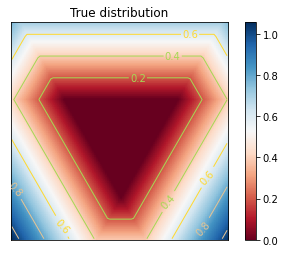

In [5]:
# Visualise the true distribution network (ignoring the distributions)
plt.figure()
plt.title('True distribution')
plot_network(true_dist_state)
plt.show()

### 2.1 Setup priors and data

In [6]:
# Setup priors
weight_prior = tfd.Normal(0.0, 0.1)
bias_prior = tfd.Normal(0.0, 0.1)

# def joint_log_prob_fn(center=None, weight_prior=None, bias_prior=None, X, y, beta, *args):  
joint_log_prob = partial(
    joint_log_prob_fn, X_train, y_train, beta=1.0, center=None, weight_prior, bias_prior, 
)

initial_state = get_initial_state(weight_prior, bias_prior, num_hidden=args.H)

NUM_PARAMS = 0
for s in initial_state:
  print("State shape", s.shape)
  NUM_PARAMS += s.shape.num_elements()
print("Total params", NUM_PARAMS)

print("")
print(initial_state)

SyntaxError: positional argument follows keyword argument (<ipython-input-6-eb3456facd95>, line 7)

In [ ]:
# Visualise untrained network

plt.figure()
plt.title('Untrained network')
plot_network(initial_state)
plt.show()

### 2.2 Train network

In [ ]:
num_iters = 2000 # number of SGD steps
save_every = 100
initial_lr = 5e-4
lr = initial_lr
num_repeats = 1

state_vars = [tf.Variable(s) for s in initial_state]
opt = tf.optimizers.Adam(learning_rate=initial_lr)
def map_loss():
  return -joint_log_prob(*state_vars)
  
@tf.function
def minimize():
  opt.minimize(map_loss, state_vars)
  
# Traces is a list, one entry per weight/bias, of values
# obtained over the course of training
traces = [[] for _ in range(len(initial_state))]

for r in range(num_repeats):
  
  for i in range(num_iters):
    if i % save_every == 0:
      for t, s in zip(traces, state_vars):
        t.append(s.numpy())
    minimize()
    
  #opt.learning_rate = 1e-1*opt.learning_rate
  
map_trace = [np.array(t) for t in traces]

# map_initial_state contains the same number of entries as initial_state
# note that this currently has 8 entries (one per weight matrix and bias)
# and each of those entries is a tensor, shapes given above
map_initial_state = [tf.constant(t[-1]) for t in map_trace]

# Graph training and test performance
plot_curves(map_trace)
plt.ylim(-1, 2)
plt.yticks(np.linspace(-1, 2, 16));

d = 0.0
for x in map_initial_state:
  d += tf.square(tf.norm(x))

print("Norm of final weight vector:")
tf.print(d)

# Set the center point for the MCMC
# !!!!!! CURRENTLY SET TO TRUE DISTRIBUTION !!!!!
#center = map_initial_state
center = true_dist_state

print(center)

In [ ]:
# Visualise the process of training
skip_size = int(len(map_trace[0])/4)

for i in range(0,len(map_trace[0]),skip_size):
  state = [tf.constant(t[i]) for t in map_trace]
  plt.figure()
  plt.title('Trained network ' + str(i))
  plot_network(state)
  plt.show()

# 3. Hamiltonian Monte Carlo from MAP

We have already trained the network by gradient descent to as close as possible to the critical locus of the loss function, now we start HMC from this stopping point of gradient descent.

* **3.1 Generate samples from the local posterior**
* **3.2 Analyse the results**
* **3.3 Estimating the RLCT**

### 3.1 Estimate the local posterior around our candidate critical point

We modify the log probability that was used for training, to use instead a tightly concentrated Gaussian prior around the weight vector `center` where we arrived at the end of training in the previous section. We then generate a Markov Chain via HMC starting from this center. The function `joint_log_prob_fn` computes the numerator of the posterior distribution at a given inverse temperature `beta`, i.e. it is `p^\beta(D_n|w)\varphi(w)` where `D_n` is specified via `X,y`.

In [ ]:
n = len(X_train)
betas = np.linspace(1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
                                 1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), args.num_betas)
print("Betas:")
print(betas)

local_weight_prior = tfd.Normal(0.0, args.prior_std_dev) # mean, std
local_bias_prior = tfd.Normal(0.0, args.prior_std_dev)

posteriors = []

# Note that the MC chains are currently using the global prior
for b in betas:
  logp = partial(joint_log_prob_fn, X_train, y_train, beta=b, 
                 center, weight_prior=weight_prior, 
                 bias_prior=bias_prior)
  posteriors.append(logp)
  
print(posteriors)

In [ ]:
# This will take a while...
mc_chains = []

i = 0

for (b,logprob) in zip(betas,posteriors):
  i += 1
  print("--------------------------------")
  print("[" + str(i) + "/" + str(args.num_betas) + "] Running MC chains for beta " + str(b))
  
  fine_chain, fine_trace, final_kernel_results = run_hmc(
    logprob,
    num_burnin_steps=args.mc_burnin_steps, # was 10000
    num_leapfrog_steps=args.mc_leapfrog_steps,
    num_adaptation_steps=args.mc_adaptation_steps, # was 8000
    num_results=args.mc_num_results, # was 20000
    step_size=args.mc_step_size,
    current_state=center)

  mc_chains.append(fine_chain)

  print("Acceptance rate:",
        fine_trace.inner_results.is_accepted[-1000:].numpy().mean())

  for c in fine_chain:
    print("ESS/step", tf.reduce_min(tfp.mcmc.effective_sample_size(c[-1000:]) / 1000).numpy())

### 3.2 Analyse the results

We generate some visualisations, to get a feeling for what this local posterior (by which we mean, the posterior with localised prior) looks like. Note that in a high-dimensional multivariate Gaussian, the expected value of the norm of a sample is `sigma \sqrt{d}` where `sigma` is the standard deviation and `d` is the dimension. So our first sanity check is to see whether the mean of norms of the samples in our Markov Chain line up with the expected norm that we would expect from sampling from the new localised prior.

In [ ]:
print("Mean sample norm from local prior Gaussian: " + str(args.prior_std_dev * np.sqrt(NUM_PARAMS)))

short_chain_length = 100

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

for (b,fc) in zip(betas,mc_chains):
  print("--------------------------------")
  print("Inverse temperature beta " + str(b))

  short_chain = []

  for c in fc:
    short_chain.append(c[-short_chain_length:])
    
  plt.figure()
  plt.title("Distances to the center")
  plot_distances(short_chain, center)
  plt.show()

We let `short_chain` be a small segment from the overall chain, and plot the angles that various components of the weight and bias vector make with their values at the beginning of `short_chain`. The cosines of angles between the full vectors are graphed as `concat`. We can see that initially the cosine of the angle is `1`, as expected, and then decreases to `0`. Note that in high dimensions two generic vectors are orthogonal, so this is expected. Some components do reach the other side of the `d`-sphere though, see for example `biases 3`.

These graphs, together with the above discussion of distances, support the hypothesis that the posterior around `center` with the localised prior, is spherical at the expected distance and not concentrated in just a small neighborhood of a point on that sphere.

In [ ]:
# Note that the dot product of high dimensional vectors is generically zero, as the orthogonal subspace
# is dim(V)-1. We graph the cos(angle) between the first point in the short_chain and the following chain steps,
# between the various weight and bias vectors, and the full weight/bias vector (concat)

#from pylab import rcParams
#rcParams['figure.figsize'] = 15, 8

for (b,fc) in zip(betas,mc_chains):
  print("--------------------------------")
  print("Inverse temperature beta " + str(b))
  
  short_chain = []

  for c in fc:
    short_chain.append(c[-short_chain_length:])
  
  plt.figure()
  plt.title("Angles with early chain point")
  plot_angles(short_chain, center)
  plt.show()

In [ ]:
#plt.figure()
#plt.title("Norm of weight vector")
#plot_distances(short_chain, [0.0*x for x in center])
#plt.show()

How far does the chain tend to travel in `200` steps? Note that on a sphere of radius `0.0001154469` any two orthogonal points will be at a distance of `0.00016326` so given the relaxation time visible in the angle graph, it would be surprising if we do not see a mean around this.

In [ ]:
#plt.figure()
#plt.title("Offset distances of chain weights")
#plot_distances_offset(short_chain, 200)
#plt.show()

### 3.3 Estimating the RLCT

Recall that the log likelihood of a weight vector, with respect to the training data and the original global prior used for training, is `joint_log_prob`.

In [ ]:
r = args.num_posterior_samples
SKIP_FACTOR = int(args.mc_num_results/r)-1

assert SKIP_FACTOR * r < args.mc_num_results

log_prob_noprior = partial(
    joint_log_prob_fn, X_train, y_train, beta=1.0, center, weight_prior=None, bias_prior=None
)

estimates = []

for (b,fc) in zip(betas,mc_chains):
  print("----------")
  print("Inverse temperature beta " + str(b))
  rlct_chain = []

  # c is a list, one entry per weight or bias vector, and each of those
  # entries is itself a list indexed by the position in the chain
  for c in fc:
    rlct_chain.append(c[-SKIP_FACTOR*r::SKIP_FACTOR])

  # nL_n(w) = - log_prob_noprior(*w)
  n_Ln_samples = []

  for i in range(r):
    w = [q[i] for q in rlct_chain]
    n_Ln_samples.append(-log_prob_noprior(*w))

  print("mean of estimates of E_w[nL_n(w)]: " + str(np.mean(n_Ln_samples)))
  print("std of estimates: " + str(np.std(n_Ln_samples)))
  estimates.append(np.mean(n_Ln_samples))
  
  #plt.figure()
  #plt.title("Samples of E_w[nL_n(w)]")
  #plt.plot(n_Ln_samples)
  #plt.show()

# Note that the log probability of a Gaussian of the form
# p(y|x,w) = 1/(2 \pi)^{d/2} exp(-1/2|| y - f(x,w) ||^2)
# is -1/2|| y - f(x,w) ||^2 + (2\pi)^{d/2} which is likely
# to be positive if the network has fit well and d is large.
# So do not be concerned if E_w[nL_n(w)] is negative.

print("")

if( len(mc_chains) > 1 ):
  plt.figure()
  plt.title("Plots of E_w[nL_n(w)] against 1/beta")
  plt.plot(1/betas, estimates, 'ro')

  m, b = np.polyfit([1/b for b in betas], estimates, 1)
  print("d/2 = " + str(NUM_PARAMS/2))
  print("Estimate of RLCT = " + str(m))
  
  # robust ls fit
  regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.5)
  regr.fit((1 / betas).reshape(args.num_betas, 1), estimates)
  robust_intercept_estimate = regr.intercept_
  # slope_estimate = min(regr.coef_[0],args.w_dim/2)
  robust_slope_estimate = regr.coef_[0]
  print("Robust estimate of RLCT = " + str(robust_slope_estimate))
  print(robust_intercept_estimate)